In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from scipy.spatial.distance import euclidean
from typing import List, Tuple
from tqdm import tqdm

import csv

from shared import dataset_local_path

In [15]:
ys = []
examples = []

with open(dataset_local_path("AirQualityUCI.csv")) as fp:
    # This is a CSV file where the separators are not commas!
    rows = csv.reader(fp, delimiter=";")
    header = next(rows)
    for row in rows:
        datapoint = {}
        # {'Date': '10/03/2004', 'Time': '18.00.00',
        #  'CO(GT)': '2,6', 'PT08.S1(CO)': '1360', 'NMHC(GT)': '150', 'C6H6(GT)': '11,9',
        #  'PT08.S2(NMHC)': '1046', 'NOx(GT)': '166', 'PT08.S3(NOx)': '1056',
        #  'NO2(GT)': '113', 'PT08.S4(NO2)': '1692', 'PT08.S5(O3)': '1268',
        #  'T': '13,6', 'RH': '48,9', 'AH': '0,7578', '': ''}
        date = None
        time = None
        for (column_name, column_value) in zip(header, row):
            if column_value == "" or column_name == "":
                continue
            elif column_name == "Date":
                date = column_value
            elif column_name == "Time":
                time = column_value
            else:
                as_float = float(column_value.replace(",", "."))
                if as_float == -200:
                    continue
                datapoint[column_name] = as_float
        if not datapoint:
            continue
        if "CO(GT)" not in datapoint:
            continue
        target = datapoint["CO(GT)"]
        del datapoint["CO(GT)"]
        ys.append(target)
        examples.append(datapoint)

In [16]:
#%% Split data: (note 90% of 90% to make vali/test smaller)

RANDOM_SEED = 1234

## split off train/validate (tv) pieces.
ex_tv, ex_test, y_tv, y_test = train_test_split(
    examples,
    ys,
    train_size=0.9,
    shuffle=True,
    random_state=RANDOM_SEED,
)
# split off train, validate from (tv) pieces.
ex_train, ex_vali, y_train, y_vali = train_test_split(
    ex_tv, y_tv, train_size=0.9, shuffle=True, random_state=RANDOM_SEED
)

In [17]:
#%% vectorize:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

feature_numbering = DictVectorizer(sparse=False)
# Learn columns from training data (again)
feature_numbering.fit(ex_train)
rX_train = feature_numbering.transform(ex_train)
rX_vali = feature_numbering.transform(ex_vali)
rX_test = feature_numbering.transform(ex_test)

scaling = StandardScaler()
X_train = scaling.fit_transform(rX_train)
X_vali = scaling.transform(rX_vali)
X_test = scaling.transform(rX_test)

print(X_train.shape, X_vali.shape)

(6215, 12) (691, 12)


In [29]:
#%% train a model:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)
print(knn.score(X_vali, y_vali))

0.9149485254385593


## Lab TODO:
 Mandatory:
 - Try some other regression models.  
 

In [30]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
print(dt.score(X_vali, y_vali))

sgd = SGDRegressor()
sgd.fit(X_train, y_train)
print(sgd.score(X_vali, y_vali))

mlp = MLPRegressor()
mlp.fit(X_train, y_train)
print(mlp.score(X_vali, y_vali))

0.8194153887149963
0.8727287911202214
0.9158678900636842


 Options:
    - Try all the other regression models.
    - Research the AirQualityUCI dataset to see what the best approaches are!
    - Try at least one, plot a (y_pred, y_actual) scatter plot (e.g., visualize correlation / R**2)
    - [Difficult] see the brute-force kNN below, try to refactor the loops out of python.

In [25]:
y_preds = knn.predict(X_vali)

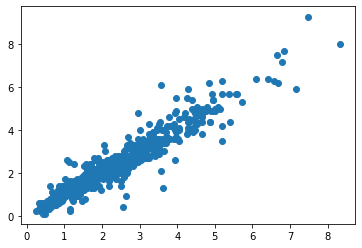

In [28]:
import matplotlib.pyplot as plt

plt.scatter(y_preds, y_vali)
plt.show()

In [24]:
# %% kNN Brute Force Below:
# Note, this is really slow (see progress bar!)
def knn_regress(
    X_train: np.ndarray, y_train: np.ndarray, x: np.ndarray, k: int = 3
) -> float:
    (num_examples, num_features) = X_train.shape
    assert num_examples == len(y_train)
    assert len(x) == num_features
    assert k < num_examples

    # fill in list of distances to training labels:
    # (distance, y_value)
    # This should be a heap, not a list, but python's heapq is annoying.
    scored_examples: List[Tuple[float, float]] = []
    for (i, row) in enumerate(X_train):
        distance = euclidean(row, x)
        scored_examples.append((distance, y_train[i]))

    # find closest-k:
    sum_y = 0.0
    for (_distance, close_y) in sorted(scored_examples)[:k]:
        sum_y += close_y
    return sum_y / k


do_slow = True

if do_slow:
    # Loop over each element of validation set, and predict based on training.
    y_vali_pred = []
    for row_index in tqdm(range(len(y_vali)), desc="kNN Brute Force"):
        example = X_vali[row_index, :]
        y_vali_pred.append(knn_regress(X_train, y_train, example, k=3))

    from sklearn.metrics import r2_score

    print("Manual KNN:", r2_score(y_vali, y_vali_pred))

kNN Brute Force: 100%|██████████| 691/691 [01:13<00:00,  9.45it/s]

Manual KNN: 0.9081994010993317


## TODO (optional, Challenging!) (efficiency / matrix ops)

Converting our Manual KNN to use scipy.spatial.distance.cdist  
*should* allow it to compute a matrix of distances between  
X_train and X_vali as 1 call to the scipy C/Fortran library.  

... This may be significantly faster.  
... You'll then end up here or so: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array  
... Seriously, I find doing this stuff annoying.  
... Good luck!  